In [ ]:
try:
  import geopandas as gpd
except:
  !pip install geopandas
  import geopandas as gpd

from shapely.geometry import box

try:
  import geohash
except:
  !pip install python-geohash
  import geohash

import pandas as pd

  Preparing metadata (setup.py) ... done
  Created wheel for python-geohash: filename=python_geohash-0.8.5-cp310-cp310-linux_x86_64.whl size=41537 sha256=89d02250ca7056bbbbe6a196b1de5dc56aa11b8910755739d9dea9c37f5b5549
  Stored in directory: /root/.cache/pip/wheels/19/e8/74/3f800ffdbb57c27a3fee3a695c7009769356448837c1f4f899
Successfully built python-geohash


In [ ]:
ecuador_shp = gpd.read_file('nxprovincias.shp')

In [ ]:
ecuador_shp = ecuador_shp.to_crs('EPSG:4326')

In [ ]:
# Unir todas las geometrías en una sola
ecuador_unido = ecuador_shp.dissolve()

In [ ]:
ecuador_geom = ecuador_unido.geometry.iloc[0]

In [ ]:
ecuador_geom

In [ ]:
# Función para obtener el polígono de un geohash
def geohash_a_poligono(gh):
    lat, lon, lat_err, lon_err = geohash.decode_exactly(gh)
    min_lat = lat - lat_err
    max_lat = lat + lat_err
    min_lon = lon - lon_err
    max_lon = lon + lon_err
    return box(min_lon, min_lat, max_lon, max_lat)

In [ ]:
# Función para obtener los geohashes que cubren el polígono
def obtener_geohashes(poligono, precision):
    from queue import Queue
    # Lista para almacenar los geohashes
    geohashes = set()
    # Cola para BFS
    queue = Queue()
    # Generar todos los geohashes de precisión 1
    geohashes_p1 = [c for c in '0123456789bcdefghjkmnpqrstuvwxyz']
    # Añadir los geohashes de precisión 1 a la cola si intersectan el polígono
    for gh in geohashes_p1:
        gh_polygon = geohash_a_poligono(gh)
        if gh_polygon.intersects(poligono):
            queue.put(gh)
    visitados = set()

    while not queue.empty():
        gh = queue.get()
        if gh in visitados:
            continue
        visitados.add(gh)
        gh_polygon = geohash_a_poligono(gh)
        if not gh_polygon.intersects(poligono):
            continue
        if len(gh) == precision:
            geohashes.add(gh)
        else:
            for c in '0123456789bcdefghjkmnpqrstuvwxyz':
                gh_hijo = gh + c
                queue.put(gh_hijo)
    return geohashes

In [ ]:
nivel_precision = 6

In [ ]:
# Obtener los geohashes de nivel 5 que cubren Ecuador
geohashes = obtener_geohashes(ecuador_geom, precision=nivel_precision)

In [ ]:
# Convertir geohashes a polígonos
geohash_poligonos = []
for gh in geohashes:
    poligono = geohash_a_poligono(gh)
    geohash_poligonos.append({'geohash': gh, 'geometry': poligono})

In [ ]:
geohash_gdf = gpd.GeoDataFrame(geohash_poligonos, crs='EPSG:4326')

<Axes: >

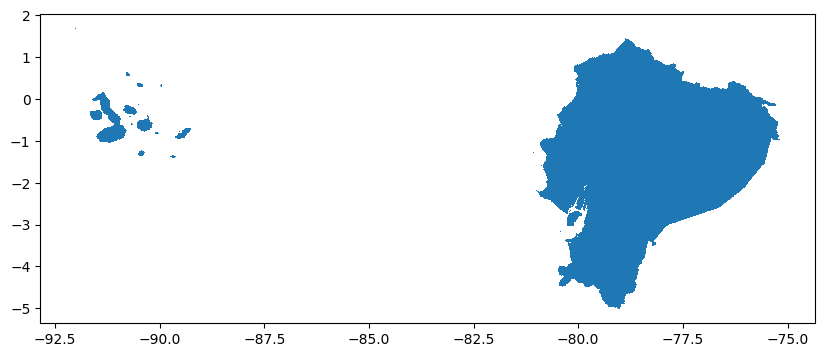

In [ ]:
geohash_gdf.plot(figsize=(10, 20))

In [ ]:
# Intersectar los geohashes con la geometría de Ecuador
geohashes_en_ecuador = gpd.overlay(geohash_gdf, ecuador_unido, how='intersection')

In [ ]:
geohashes_en_ecuador.plot(figsize=(10, 10))

In [ ]:
# Obtener los geohashes que cubren Ecuador
geohashes_ecuador = geohashes_en_ecuador['geohash'].unique()

# Mostrar los geohashes
print(geohashes_ecuador)

In [ ]:
'ecuador_geohashes_nivel'+str(nivel_precision)+'.geojson'

In [ ]:
# Opcional: Guardar los geohashes y sus polígonos en un archivo GeoJSON
geohashes_en_ecuador[['geohash','geometry']].to_file('ecuador_geohashes_nivel'+str(nivel_precision)+'.geojson', driver='GeoJSON')